<a href="https://colab.research.google.com/github/balandongiv/mmocr_tutorial/blob/main/retrain_detection_model_from_cpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMOCR Tutorial

Welcome to MMOCR! This is the **unofficial** colab tutorial for using MMOCR. In this tutorial, you will learn how to

- Resume training the detection model from existing check point

# Install MMOCR

When installing dependencies for mmocr, please ensure that all the dependency versions are compatible with each other. For instance, if CUDA 10.1 is installed, then the Pytorch version must be compatible with cu10.1. Please see [getting_started.md](docs/getting_started.md) for more details. 

In [ ]:
%cd ..

/


### Check PyTorch version

In [ ]:
!pip show torch

Name: torch
Version: 1.11.0+cu113
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchaudio, fastai


### Install Dependencies 

In [ ]:
# Install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html

# Install mmdetection
!pip install mmdet

# # Install mmocr
!git clone https://github.com/open-mmlab/mmocr.git
%cd mmocr
!pip install -r requirements.txt
!pip install -v -e .

!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html
     |████████████████████████████████| 37.7 MB 9.1 MB/s 
     |████████████████████████████████| 190 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.1 MB/s 
Cloning into 'mmocr'...
remote: Enumerating objects: 6569, done.
remote: Counting objects: 100% (502/502), done.
remote: Compressing objects: 100% (365/365), done.
remote: Total 6569 (delta 243), reused 276 (delta 130), pack-reused 6067
Receiving objects: 100% (6569/6569), 13.18 MiB | 35.70 MiB/s, done.
Resolving deltas: 100% (4021/4021), done.
/mmocr
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 603 kB 5.1 MB/s 
  Installing build dependencies 

### Check Installed Dependencies Versions

In [ ]:
import mmcv
import matplotlib.pyplot as plt 
import os
from pathlib import Path

import wget

# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(mmcv.__version__)
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check mmocr installation
import mmocr
print(mmocr.__version__)

%cd /mmocr/
!ls

1.11.0+cu113 True
2.24.1
1.5.1
11.3
GCC 7.3
0.6.0
/mmocr
CITATION.cff  docs	   mmocr.egg-info   requirements      setup.py
configs       LICENSE	   model-index.yml  requirements.txt  tests
demo	      MANIFEST.in  README.md	    resources	      tools
docker	      mmocr	   README_zh-CN.md  setup.cfg


#Perform Training on a Toy Dataset with MMOCR Text Detector
We now demonstrate how to perform training with an MMOCR text detector. Since training a full academic dataset is time consuming (usually takes about several hours), we will train on the toy dataset for the textsnake text detector model and visualize the predictions.

Training a dataset usually consists of the following steps:
1. Convert the dataset into a format supported by MMOCR (e.g. COCO for text detection). The annotation file can be in either .txt or .lmdb format, depending on the size of the dataset. This step is usually applicable to customized datasets, since the datasets and annotation files we provide are already in supported formats. 
2. Modify the config for training. 
3. Train the model. 



## About the Toy Dataset

In this tutorial, we will be working with the dataset under the folder `toy_dataset`. 

Each of the image have the accompnying `annotation` file generated using the `labelme`

The images were stored under the following path

`/mmocr/tests/data/toy_dataset/imgs/test`

The annotation were stored under  the following path

`/mmocr/tests/data/toy_dataset/labelme`




We first get a sense of what the toy dataset looks like by visualizing one of the images and labels. 

/


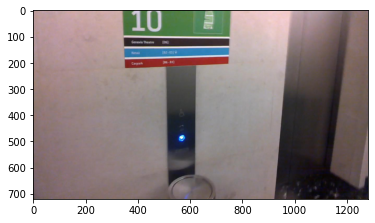

In [ ]:
#To ensure we are in the root directory
%cd .. 

img = mmcv.imread('/mmocr/tests/data/toy_dataset/imgs/test/img_1.jpg')

plt.imshow(mmcv.bgr2rgb(img))
plt.show()

Let visualise the annotation

In [ ]:
!cat /mmocr/tests/data/toy_dataset/labelme/img_1.json

## Prepare Annotation to MMOCR format 

Since the annotations are in COCO format, we need to firstly convert annotation in labelme format to MMOCR's annotation format using the `labelme_converter.py`.

For this particular example, we will convert the labelme format annotation in `/mmocr/tests/data/toy_dataset/labelme` to MMOCR detection labels instances_training `.txt` and export the cropped image patches for recognition task to `/mmocr/tests/data/toy_dataset/crops`. It is worth to note that the following setting would not output the `test_label.txt` as there is no test set. This information is important  when assigning  `test_anno_file1` to `train_label.txt` in subsequent step.

In Google colab, it is essential to add a `!` before the Python command.


MMOCR will force the `det` annotation to be in `.txt` format, and automatically save the file as `instances_training.txt`

In [ ]:
!python /mmocr/tools/data/common/labelme_converter.py /mmocr/tests/data/toy_dataset/labelme /mmocr/tests/data/toy_dataset/imgs/test /mmocr/tests/data/toy_dataset --tasks det

[>>] 10/10, 3883.6 task/s, elapsed: 0s, ETA:     0s
finish


Lets visualise the MMOCR detection labels instances_training `.jsonl`

In [ ]:
!cat /mmocr/tests/data/toy_dataset/instances_training.txt

{"file_name": "img_5.jpg", "height": 720, "width": 1280, "annotations": [{"iscrowd": 1, "category_id": 1, "bbox": [405, 409, 32, 52], "segmentation": [[408, 409, 437, 436, 434, 461, 405, 433]], "text": "###"}, {"iscrowd": 1, "category_id": 1, "bbox": [435, 434, 8, 33], "segmentation": [[437, 434, 443, 440, 441, 467, 435, 462]], "text": "###"}]}
{"file_name": "img_10.jpg", "height": 720, "width": 1280, "annotations": [{"iscrowd": 1, "category_id": 1, "bbox": [260, 138, 24, 20], "segmentation": [[261, 138, 284, 140, 279, 158, 260, 158]], "text": "###"}, {"iscrowd": 0, "category_id": 1, "bbox": [288, 138, 129, 23], "segmentation": [[288, 138, 417, 140, 416, 161, 290, 157]], "text": "HarbourFront"}, {"iscrowd": 0, "category_id": 1, "bbox": [743, 145, 37, 18], "segmentation": [[743, 145, 779, 146, 780, 163, 746, 163]], "text": "CC22"}, {"iscrowd": 0, "category_id": 1, "bbox": [783, 129, 50, 26], "segmentation": [[783, 129, 831, 132, 833, 155, 785, 153]], "text": "bua"}, {"iscrowd": 1, "cate

# Download Pre-train Text Detection Model

Lets download the train model and stored under the folder `model_pt`

In [ ]:

# udet='https://download.openmmlab.com/mmocr/textdet/textsnake/textsnake_r50_fpn_unet_1200e_ctw1500-27f65b64.pth'
# urec='https://download.openmmlab.com/mmocr/textrecog/sar/sar_r31_parallel_decoder_academic-dba3a4a3.pth'
# pstore=os.path.join(str(Path.cwd()), 'model_pt/')

# if not os.path.exists(pstore): os.mkdir(pstore)

# for durl in [udet,urec]:
#     if not os.path.exists(os.path.join(pstore,os.path.split(durl)[-1])): # Check if file already downloaded/available
#         wget.download(durl,pstore)

In colab, this files will be saved at

`/model_pt/sar_r31_parallel_decoder_academic-dba3a4a3.pth`

`/model_pt/textsnake_r50_fpn_unet_1200e_ctw1500-27f65b64.pth`


# Training on a Single GPU

## Setting the configuration

The MMOCR's config system incorporate modular and inheritance design, which is convenient to conduct various experiments.

Lets visualise the textsnake_r50_fpn_unet_1200e_ctw1500config.

In [ ]:
from mmcv import Config
cfg = Config.fromfile('/mmocr/configs/textdet/textsnake/textsnake_r50_fpn_unet_1200e_ctw1500.py') 
# print(f'Config:\n{cfg.pretty_text}')


Lets update the path for the images and annotation files

In [ ]:
dataset_type = 'OCRDataset'

root ='/mmocr/tests/data/toy_dataset' # Location where the annotation and crop images are being stored

img_prefix =os.path.join(root,'imgs','test')


train_anno_file1 = os.path.join(root,'instances_training.txt') 
test_anno_file1 = os.path.join(root,'instances_training.txt') # Assume we use similar train and test data set ATM.


# Set up working dir to save files and logs.
work_dir = '/mmocr/demo/tutorial_exps'


loader_dt_train = dict(type='AnnFileLoader',
                            repeat=1,                   
                            file_format='txt',  # only txt and lmdb
                            file_storage_backend='disk',
                            parser=dict(type='LineJsonParser',
                                        keys=['filename', 'text']))

loader_dt_test = dict(type = 'AnnFileLoader',
                        repeat = 1,
                        file_format = 'txt',  # only txt and lmdb
                        file_storage_backend = 'disk',
                        parser = dict(type = 'LineJsonParser',
                                    keys = ['filename', 'text']))



train = dict(
    type='OCRDataset',
    ann_file=train_anno_file1,
    img_prefix=img_prefix,
    loader=loader_dt_train,
    pipeline=None)
test = dict(
    type='OCRDataset',
    ann_file=test_anno_file1,
    img_prefix=img_prefix,
    loader=loader_dt_test,
    pipeline=None)


train_list = [train]
test_list = [test]


Lets update this into the `cfg` 

In [ ]:
cfg.dataset_type=dataset_type
cfg.data_root=root
cfg.train=train
cfg.test=test
cfg.train_list=train_list
cfg.test_list=test_list
cfg.work_dir=work_dir

cfg.data.train.datasets=cfg.train_list
cfg.data.val.datasets=cfg.test_list
cfg.data.test.datasets=cfg.test_list

In order to perform  on colab, we need to adjust the config values to accommodate some of the settings of colab such as the number of GPU available.

In [ ]:
from mmdet.apis import set_random_seed


# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.

# I am not sure should we change this? especially the `lr`

# cfg.optimizer=dict(type='SGD', 
#                    lr=0.007,
#                    momentum=0.9, 
#                    weight_decay=0.0001)

# I am not sure should we change this?
# cfg.lr_config = dict(policy='poly', power=0.9, min_lr=1e-07, by_epoch=True)


cfg.log_config = dict(
                  interval = 40,  # Choose to log training results every 40 images to reduce the size of log file. 
                  hooks = [dict(type = 'TextLoggerHook')])

# Set seed thus the results are more reproducible
seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let also limit the training to only 5 epochs

cfg.runner = dict(type='EpochBasedRunner', max_epochs=5) # Default max_epochs is 1200


print(f'Config:\n{cfg.pretty_text}')

Config:
log_config = dict(interval=40, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
optimizer = dict(type='SGD', lr=0.007, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=None)
lr_config = dict(policy='poly', power=0.9, min_lr=1e-07, by_epoch=True)
runner = dict(type='EpochBasedRunner', max_epochs=5)
checkpoint_config = dict(interval=100)
model = dict(
    type='TextSnake',
    backbone=dict(
        type='mmdet.ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=-1,
        norm_cfg=dict(type='BN', requires_grad=True),
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50'),
        norm_eval=True,
        style='caffe'),
    neck=dict(
        type='FPN_UNet', in_channels=[256, 512, 1024, 2048], out_channels=32),
    bbox_head=dict(
   


Finally, we train the textsnake text detection on the toy dataset for five epochs.

This steps took about ~ 5 minutes to complete or <15 if Colab is connected with GPU


In [17]:
#@title Default title text
from mmocr.datasets import build_dataset
from mmocr.models import build_detector
from mmocr.apis import train_detector
import os.path as osp

# Build dataset
datasets = [build_dataset(cfg.data.train)] 

# Build the detector
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-05-26 06:44:14,633 - mmocr - INFO - Start running, host: root@eaf96647d1e6, work_dir: /mmocr/demo/tutorial_exps
2022-05-26 06:44:14,634 - mmocr - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) EvalHook      

Streaming output truncated to the last 5000 lines.
load index 8 with error key filename not in line json {'file_name': 'img_1.jpg', 'height': 720, 'width': 1280, 'annotations': [{'iscrowd': 0, 'category_id': 1, 'bbox': [377, 117, 88, 13], 'segmentation': [[377, 117, 463, 117, 465, 130, 378, 130]], 'text': 'Genaxis Theatre'}, {'iscrowd': 0, 'category_id': 1, 'bbox': [493, 115, 26, 16], 'segmentation': [[493, 115, 519, 115, 519, 131, 493, 131]], 'text': '[06]'}, {'iscrowd': 1, 'category_id': 1, 'bbox': [374, 155, 35, 15], 'segmentation': [[374, 155, 409, 155, 409, 170, 374, 170]], 'text': '###'}, {'iscrowd': 0, 'category_id': 1, 'bbox': [492, 151, 59, 19], 'segmentation': [[492, 151, 551, 151, 551, 170, 492, 170]], 'text': '62-03'}, {'iscrowd': 0, 'category_id': 1, 'bbox': [376, 198, 46, 14], 'segmentation': [[376, 198, 422, 198, 422, 212, 376, 212]], 'text': 'Carpark'}, {'iscrowd': 1, 'category_id': 1, 'bbox': [494, 189, 45, 17], 'segmentation': [[494, 190, 539, 189, 539, 205, 494, 206]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



load index 4 with error key filename not in line json {'file_name': 'img_9.jpg', 'height': 720, 'width': 1280, 'annotations': [{'iscrowd': 0, 'category_id': 1, 'bbox': [342, 206, 42, 22], 'segmentation': [[344, 206, 384, 207, 381, 228, 342, 227]], 'text': 'EXIT'}, {'iscrowd': 1, 'category_id': 1, 'bbox': [42, 183, 52, 29], 'segmentation': [[47, 183, 94, 183, 83, 212, 42, 206]], 'text': '###'}, {'iscrowd': 0, 'category_id': 1, 'bbox': [913, 515, 168, 80], 'segmentation': [[913, 515, 1068, 526, 1081, 595, 921, 578]], 'text': 'STAGE'}, {'iscrowd': 1, 'category_id': 1, 'bbox': [240, 291, 33, 7], 'segmentation': [[240, 291, 273, 291, 273, 298, 240, 297]], 'text': '###'}]}
load index 3 with error key filename not in line json {'file_name': 'img_3.jpg', 'height': 720, 'width': 1280, 'annotations': [{'iscrowd': 0, 'category_id': 1, 'bbox': [58, 71, 136, 52], 'segmentation': [[58, 80, 191, 71, 194, 114, 61, 123]], 'text': 'fusionopolis'}, {'iscrowd': 1, 'category_id': 1, 'bbox': [147, 21, 29, 1

KeyboardInterrupt: ignored

# Resume Training From Existing Check Point

In [ ]:
# !python /mmocr/tools/train.py cfg --resume-from /mmocr/demo/tutorial_exps/textsnake_r50_fpn_unet_1200e_ctw1500-27f65b64.pth
